# Lab 6
### Kovaleva Maria

##Task

Train multiple MLP models on a toy dataset. Make a random pruning of the models. Visualize their parameter projection onto 2d-space with color corresponding to accuracy.


## Solution

In [1]:
import jax
from sklearn import datasets
from sklearn.model_selection import train_test_split
from jax import numpy as jnp
import numpy as np
from jax import grad, value_and_grad

from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [2]:
def one_hot_encoding(a):
  b = np.zeros((a.size, a.max() + 1))
  b[np.arange(a.size), a] = 1
  return b

11490434/11490434 [==============================] - 2s 0us/step


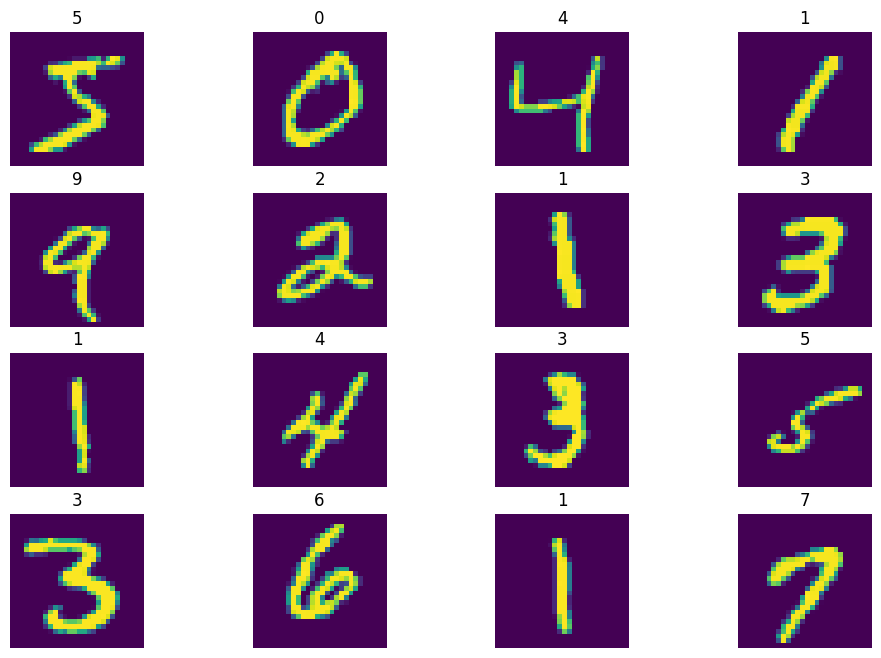

(60000, 784) (60000, 10) (10000, 784) (10000, 10)


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

def plot_samples(x, y, figsize=(12, 8), num_rows=4, num_columns=4, title=None):
    
    if len(x) != len(y):
        raise ValueError("Number of images and number of labels don't match!")
    
    _, ax = plt.subplots(num_rows, num_columns, figsize=figsize)
    
    for i in range(num_rows * num_columns):
        try:
            img = x[i]
            label = str(y[i])
            ax[i // num_columns, i % num_columns].imshow(img)
            ax[i // num_columns, i % num_columns].set_title(label)
            ax[i // num_columns, i % num_columns].axis("off")
        except:
            pass
    
    if title:
        plt.suptitle(str(title))
    plt.show()

plot_samples(x_train[:16], [y for y in y_train[:16]])

x_train = jnp.array(x_train / 255.)
x_test = jnp.array(x_test / 255.)

x_train, x_test = x_train.reshape(len(x_train),-1), x_test.reshape(len(x_test),-1)
y_train = one_hot_encoding(y_train.reshape(-1))#.astype("int")
y_test = one_hot_encoding(y_test.reshape(-1))#.astype("int")

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

In [4]:
samples, features = x_train.shape
classes = np.unique(y_train, axis = 0)
samples, features, classes

(60000,
 784,
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

In [5]:
def InitializeWeights(layer_sizes, seed):
    weights = []
    for i, units in enumerate(layer_sizes):
        if i == 0:
            w = jax.random.uniform(key=seed, shape=(units, features), minval=-1.0, maxval=1.0, dtype=jnp.float32)
        else:
            w = jax.random.uniform(key=seed, shape=(units, layer_sizes[i-1]), minval=-1.0, maxval=1.0,
                                   dtype=jnp.float32)

        b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(units,), dtype=jnp.float32)

        weights.append([w,b])

    return weights

In [6]:
def Relu(x):
    return jnp.maximum(x, jnp.zeros_like(x)) # max(0,x)

def LogSoftmax(x):
    x_off = x - jnp.max(x)
    return x_off - jnp.log(jnp.sum(jnp.exp(x_off)))

def LinearLayer(weights, input_data, activation=lambda x: x, mask = None):
    w, b = weights
    if mask == None:
        mask_w, mask_b = jnp.ones(w.shape), jnp.ones(b.shape)
    else:
        mask_w, mask_b = mask
    out = jnp.dot(input_data, w.T * mask_w.T) + b * mask_b
    return activation(out)

def ForwardPass(weights, input_data, mask = None):
    if mask == None:
        layer_out = input_data
        for i in range(len(weights[:-1])):
            layer_out = LinearLayer(weights[i], layer_out, Relu)

        preds = LinearLayer(weights[-1], layer_out, LogSoftmax)
    else:
        layer_out = input_data
        for i in range(len(weights[:-1])):
            layer_out = LinearLayer(weights[i], layer_out, Relu, mask[i])

        preds = LinearLayer(weights[-1], layer_out, LogSoftmax, mask[-1])
        pass
    return preds.squeeze()

def Loss(weights, input_data, actual, mask):
    preds = ForwardPass(weights, input_data, mask)

    return -jnp.sum((actual * preds), axis = 1).mean()
  
def Accuracy(weights, input_data, actual, mask):
    preds = ForwardPass(weights, input_data)
    preds_ind = jnp.argmax(preds, axis = 1)
    actual_ind = jnp.argmax(actual, axis = 1)
    return jnp.mean(preds_ind == actual_ind)

def CalculateGradients(weights, input_data, actual, mask):
    Grad_Loss = grad(Loss)
    gradients = Grad_Loss(weights, input_data, actual, mask)
    return gradients

In [7]:
def TrainModel(weights, X, Y, learning_rate, epochs, mask, verbose_epoches = 100):
    losses = []
    accuracies = []
    saved_weights = {}
    for i in range(epochs):
        
        gradients = CalculateGradients(weights, X, Y, mask)
        loss = Loss(weights, X, Y, mask)
        accuracy = Accuracy(weights, X, Y, mask)

        ## Update Weights
        for j in range(len(weights)):
            weights[j][0] -= learning_rate * gradients[j][0] ## Update Weights
            weights[j][1] -= learning_rate * gradients[j][1] ## Update Biases

        if i % verbose_epoches == 0:
            print("Epoch : {} \t Loss : {:.2f} \t Accuracy : {:2f}".format(i, loss, accuracy))
            weights_to_save = []
            for weight in weights:
                weights_to_save.append([jnp.copy(weight[0]), jnp.copy(weight[1])])
            saved_weights[i] = {"accuracy": accuracy, "loss": loss, "weights": weights_to_save}
        accuracies.append(accuracy)
        losses.append(loss)
    return losses, accuracies, saved_weights

Epoch : 0 	 Loss : 66.71 	 Accuracy : 0.086633
Epoch : 100 	 Loss : 19.41 	 Accuracy : 0.263333
Epoch : 200 	 Loss : 15.55 	 Accuracy : 0.347017
Epoch : 300 	 Loss : 14.17 	 Accuracy : 0.402233
Epoch : 400 	 Loss : 13.53 	 Accuracy : 0.447200
Epoch : 500 	 Loss : 13.18 	 Accuracy : 0.484817
Epoch : 600 	 Loss : 12.96 	 Accuracy : 0.514383
Epoch : 700 	 Loss : 12.81 	 Accuracy : 0.537767
Epoch : 800 	 Loss : 12.71 	 Accuracy : 0.557133
Epoch : 900 	 Loss : 12.63 	 Accuracy : 0.574100
Epoch : 1000 	 Loss : 12.56 	 Accuracy : 0.590200
Epoch : 1100 	 Loss : 12.51 	 Accuracy : 0.602533
Epoch : 1200 	 Loss : 12.46 	 Accuracy : 0.614317
Epoch : 1300 	 Loss : 12.42 	 Accuracy : 0.624800
Epoch : 1400 	 Loss : 12.38 	 Accuracy : 0.634600
Epoch : 1500 	 Loss : 12.35 	 Accuracy : 0.642900
Epoch : 1600 	 Loss : 12.32 	 Accuracy : 0.650817
Epoch : 1700 	 Loss : 12.30 	 Accuracy : 0.657850
Epoch : 1800 	 Loss : 12.27 	 Accuracy : 0.665083
Epoch : 1900 	 Loss : 12.25 	 Accuracy : 0.671733
Epoch : 2000

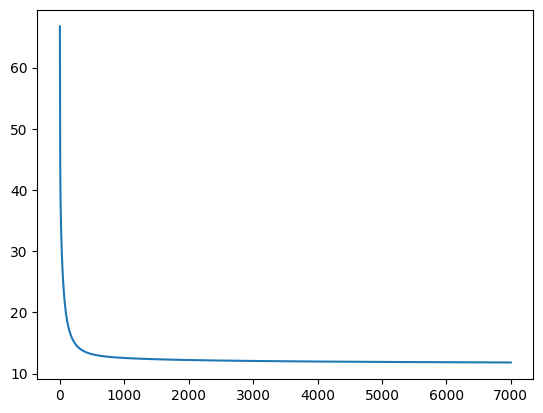

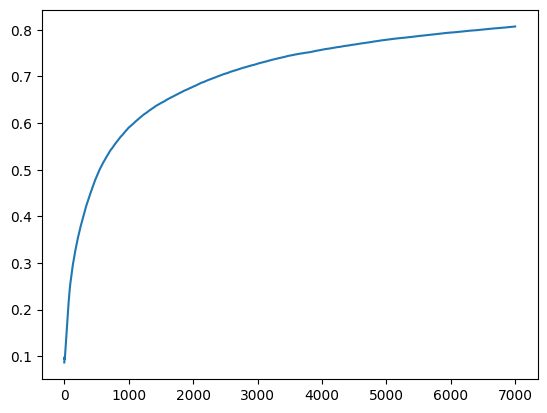

Epoch : 0 	 Loss : 95.77 	 Accuracy : 0.091633
Epoch : 100 	 Loss : 21.06 	 Accuracy : 0.317583
Epoch : 200 	 Loss : 16.62 	 Accuracy : 0.422650
Epoch : 300 	 Loss : 14.72 	 Accuracy : 0.466333
Epoch : 400 	 Loss : 13.72 	 Accuracy : 0.500667
Epoch : 500 	 Loss : 13.18 	 Accuracy : 0.532567
Epoch : 600 	 Loss : 12.87 	 Accuracy : 0.563667
Epoch : 700 	 Loss : 12.67 	 Accuracy : 0.588400
Epoch : 800 	 Loss : 12.55 	 Accuracy : 0.610500
Epoch : 900 	 Loss : 12.46 	 Accuracy : 0.627483
Epoch : 1000 	 Loss : 12.39 	 Accuracy : 0.642717
Epoch : 1100 	 Loss : 12.34 	 Accuracy : 0.655083
Epoch : 1200 	 Loss : 12.29 	 Accuracy : 0.666767
Epoch : 1300 	 Loss : 12.26 	 Accuracy : 0.676700
Epoch : 1400 	 Loss : 12.23 	 Accuracy : 0.685567
Epoch : 1500 	 Loss : 12.20 	 Accuracy : 0.694133
Epoch : 1600 	 Loss : 12.18 	 Accuracy : 0.701383
Epoch : 1700 	 Loss : 12.15 	 Accuracy : 0.707850
Epoch : 1800 	 Loss : 12.13 	 Accuracy : 0.714000
Epoch : 1900 	 Loss : 12.12 	 Accuracy : 0.719733
Epoch : 2000

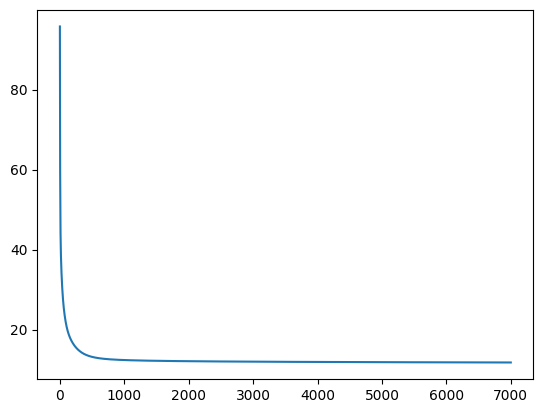

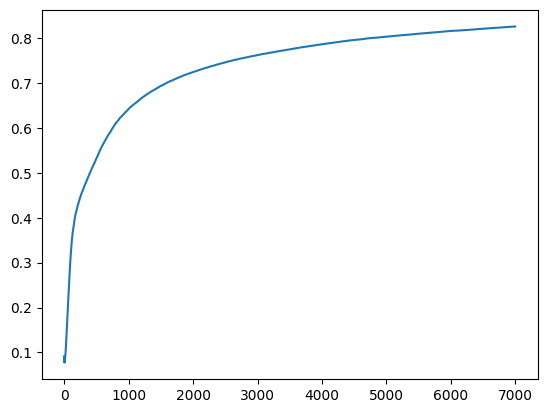

Epoch : 0 	 Loss : 74.77 	 Accuracy : 0.111817
Epoch : 100 	 Loss : 19.89 	 Accuracy : 0.274633
Epoch : 200 	 Loss : 15.87 	 Accuracy : 0.377700
Epoch : 300 	 Loss : 14.22 	 Accuracy : 0.442933
Epoch : 400 	 Loss : 13.42 	 Accuracy : 0.492600
Epoch : 500 	 Loss : 13.00 	 Accuracy : 0.534083
Epoch : 600 	 Loss : 12.74 	 Accuracy : 0.568567
Epoch : 700 	 Loss : 12.58 	 Accuracy : 0.596417
Epoch : 800 	 Loss : 12.47 	 Accuracy : 0.619817
Epoch : 900 	 Loss : 12.40 	 Accuracy : 0.638067
Epoch : 1000 	 Loss : 12.34 	 Accuracy : 0.652267
Epoch : 1100 	 Loss : 12.29 	 Accuracy : 0.664050
Epoch : 1200 	 Loss : 12.25 	 Accuracy : 0.674800
Epoch : 1300 	 Loss : 12.22 	 Accuracy : 0.683433
Epoch : 1400 	 Loss : 12.20 	 Accuracy : 0.691683
Epoch : 1500 	 Loss : 12.17 	 Accuracy : 0.698483
Epoch : 1600 	 Loss : 12.15 	 Accuracy : 0.704783
Epoch : 1700 	 Loss : 12.13 	 Accuracy : 0.711117
Epoch : 1800 	 Loss : 12.12 	 Accuracy : 0.716317
Epoch : 1900 	 Loss : 12.10 	 Accuracy : 0.721267
Epoch : 2000

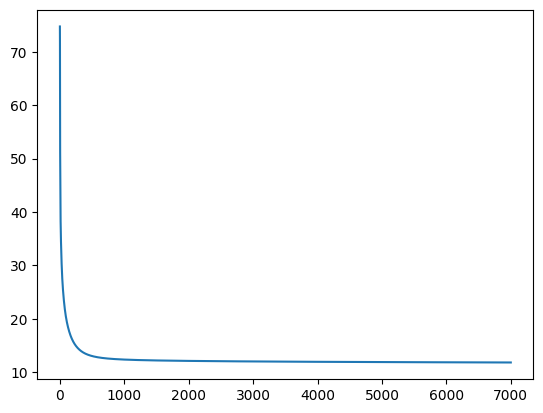

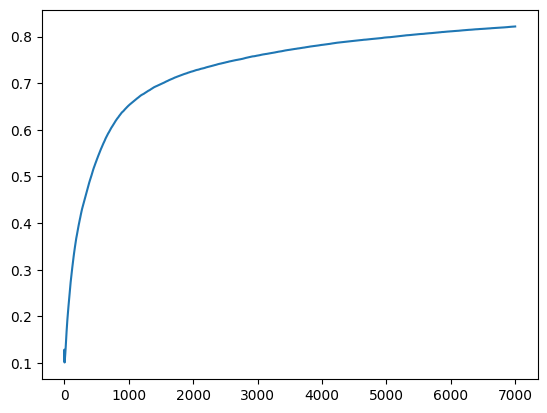

Epoch : 0 	 Loss : 66.13 	 Accuracy : 0.081900
Epoch : 100 	 Loss : 20.75 	 Accuracy : 0.203917
Epoch : 200 	 Loss : 16.03 	 Accuracy : 0.327683
Epoch : 300 	 Loss : 14.30 	 Accuracy : 0.412567
Epoch : 400 	 Loss : 13.52 	 Accuracy : 0.466517
Epoch : 500 	 Loss : 13.10 	 Accuracy : 0.507350
Epoch : 600 	 Loss : 12.86 	 Accuracy : 0.538317
Epoch : 700 	 Loss : 12.70 	 Accuracy : 0.564233
Epoch : 800 	 Loss : 12.58 	 Accuracy : 0.586267
Epoch : 900 	 Loss : 12.50 	 Accuracy : 0.603883
Epoch : 1000 	 Loss : 12.43 	 Accuracy : 0.618250
Epoch : 1100 	 Loss : 12.38 	 Accuracy : 0.630567
Epoch : 1200 	 Loss : 12.33 	 Accuracy : 0.642400
Epoch : 1300 	 Loss : 12.30 	 Accuracy : 0.653100
Epoch : 1400 	 Loss : 12.26 	 Accuracy : 0.662183
Epoch : 1500 	 Loss : 12.24 	 Accuracy : 0.670950
Epoch : 1600 	 Loss : 12.21 	 Accuracy : 0.678700
Epoch : 1700 	 Loss : 12.19 	 Accuracy : 0.685533
Epoch : 1800 	 Loss : 12.17 	 Accuracy : 0.691667
Epoch : 1900 	 Loss : 12.15 	 Accuracy : 0.697417
Epoch : 2000

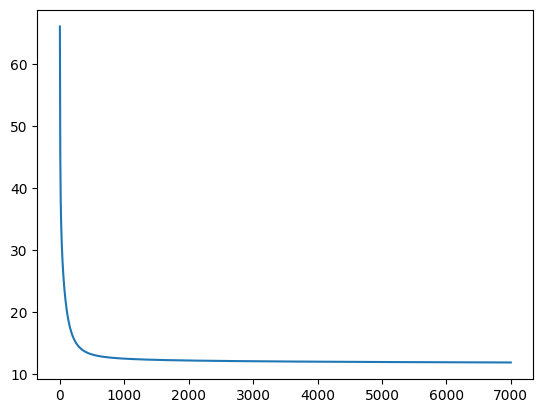

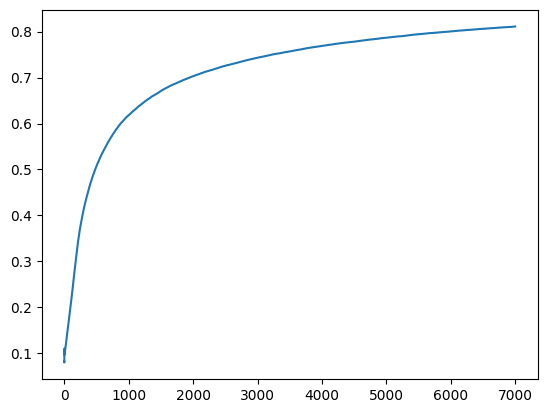

Epoch : 0 	 Loss : 94.32 	 Accuracy : 0.104300
Epoch : 100 	 Loss : 19.95 	 Accuracy : 0.247567
Epoch : 200 	 Loss : 15.82 	 Accuracy : 0.348683
Epoch : 300 	 Loss : 14.25 	 Accuracy : 0.411767
Epoch : 400 	 Loss : 13.49 	 Accuracy : 0.462300
Epoch : 500 	 Loss : 13.09 	 Accuracy : 0.503067
Epoch : 600 	 Loss : 12.85 	 Accuracy : 0.536583
Epoch : 700 	 Loss : 12.69 	 Accuracy : 0.562733
Epoch : 800 	 Loss : 12.58 	 Accuracy : 0.583317
Epoch : 900 	 Loss : 12.50 	 Accuracy : 0.600783
Epoch : 1000 	 Loss : 12.44 	 Accuracy : 0.615400
Epoch : 1100 	 Loss : 12.39 	 Accuracy : 0.628833
Epoch : 1200 	 Loss : 12.35 	 Accuracy : 0.639983
Epoch : 1300 	 Loss : 12.32 	 Accuracy : 0.650017
Epoch : 1400 	 Loss : 12.29 	 Accuracy : 0.659933
Epoch : 1500 	 Loss : 12.26 	 Accuracy : 0.668450
Epoch : 1600 	 Loss : 12.23 	 Accuracy : 0.675317
Epoch : 1700 	 Loss : 12.21 	 Accuracy : 0.681717
Epoch : 1800 	 Loss : 12.19 	 Accuracy : 0.688300
Epoch : 1900 	 Loss : 12.17 	 Accuracy : 0.694867
Epoch : 2000

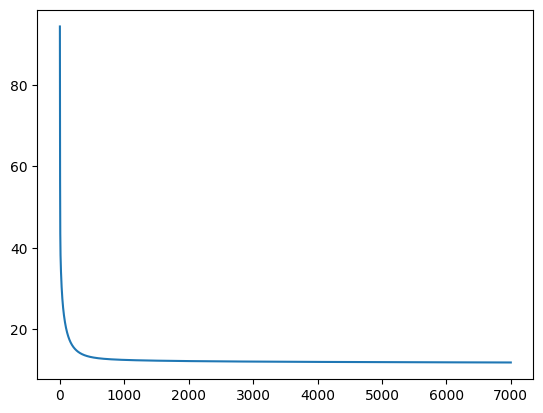

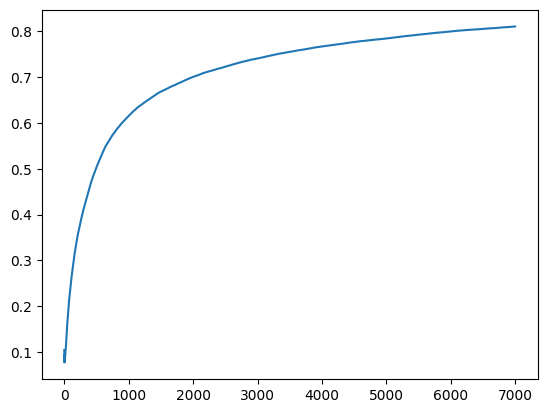

Epoch : 0 	 Loss : 83.03 	 Accuracy : 0.100117
Epoch : 100 	 Loss : 20.17 	 Accuracy : 0.247250
Epoch : 200 	 Loss : 16.10 	 Accuracy : 0.338700
Epoch : 300 	 Loss : 14.45 	 Accuracy : 0.405000
Epoch : 400 	 Loss : 13.65 	 Accuracy : 0.458867
Epoch : 500 	 Loss : 13.20 	 Accuracy : 0.502617
Epoch : 600 	 Loss : 12.93 	 Accuracy : 0.537533
Epoch : 700 	 Loss : 12.75 	 Accuracy : 0.564883
Epoch : 800 	 Loss : 12.63 	 Accuracy : 0.589483
Epoch : 900 	 Loss : 12.54 	 Accuracy : 0.608733
Epoch : 1000 	 Loss : 12.47 	 Accuracy : 0.624350
Epoch : 1100 	 Loss : 12.41 	 Accuracy : 0.638283
Epoch : 1200 	 Loss : 12.36 	 Accuracy : 0.649983
Epoch : 1300 	 Loss : 12.32 	 Accuracy : 0.660333
Epoch : 1400 	 Loss : 12.29 	 Accuracy : 0.669617
Epoch : 1500 	 Loss : 12.26 	 Accuracy : 0.678500
Epoch : 1600 	 Loss : 12.23 	 Accuracy : 0.687300
Epoch : 1700 	 Loss : 12.21 	 Accuracy : 0.694033
Epoch : 1800 	 Loss : 12.19 	 Accuracy : 0.700600
Epoch : 1900 	 Loss : 12.17 	 Accuracy : 0.707150
Epoch : 2000

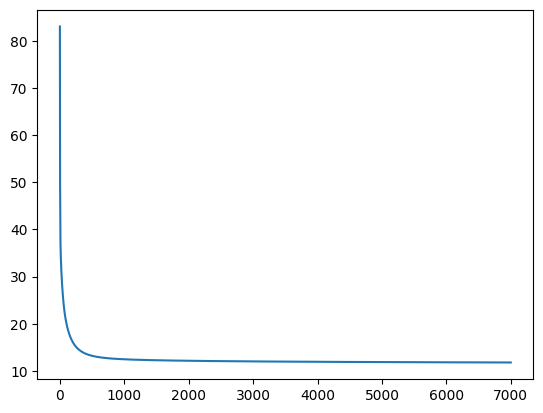

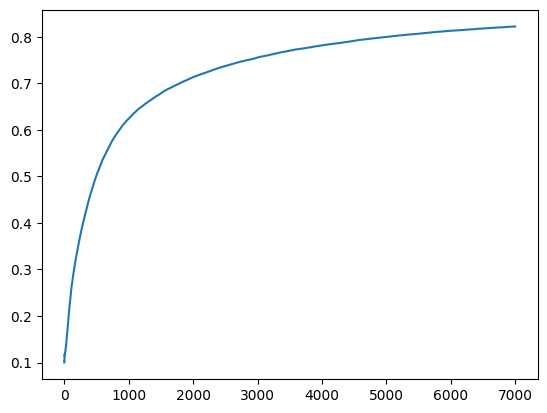

Epoch : 0 	 Loss : 72.04 	 Accuracy : 0.079733
Epoch : 100 	 Loss : 19.67 	 Accuracy : 0.297283
Epoch : 200 	 Loss : 16.04 	 Accuracy : 0.369717
Epoch : 300 	 Loss : 14.44 	 Accuracy : 0.420383
Epoch : 400 	 Loss : 13.63 	 Accuracy : 0.461717
Epoch : 500 	 Loss : 13.18 	 Accuracy : 0.497250
Epoch : 600 	 Loss : 12.91 	 Accuracy : 0.529200
Epoch : 700 	 Loss : 12.74 	 Accuracy : 0.555517
Epoch : 800 	 Loss : 12.62 	 Accuracy : 0.578033
Epoch : 900 	 Loss : 12.53 	 Accuracy : 0.597183
Epoch : 1000 	 Loss : 12.46 	 Accuracy : 0.613733
Epoch : 1100 	 Loss : 12.41 	 Accuracy : 0.628183
Epoch : 1200 	 Loss : 12.36 	 Accuracy : 0.641033
Epoch : 1300 	 Loss : 12.32 	 Accuracy : 0.651533
Epoch : 1400 	 Loss : 12.29 	 Accuracy : 0.660867
Epoch : 1500 	 Loss : 12.26 	 Accuracy : 0.670150
Epoch : 1600 	 Loss : 12.24 	 Accuracy : 0.678883
Epoch : 1700 	 Loss : 12.22 	 Accuracy : 0.686733
Epoch : 1800 	 Loss : 12.20 	 Accuracy : 0.693417
Epoch : 1900 	 Loss : 12.18 	 Accuracy : 0.699050
Epoch : 2000

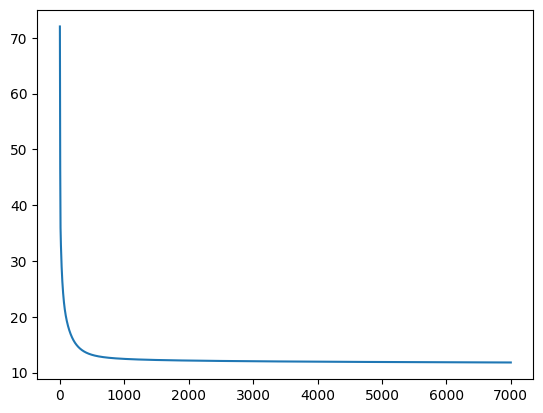

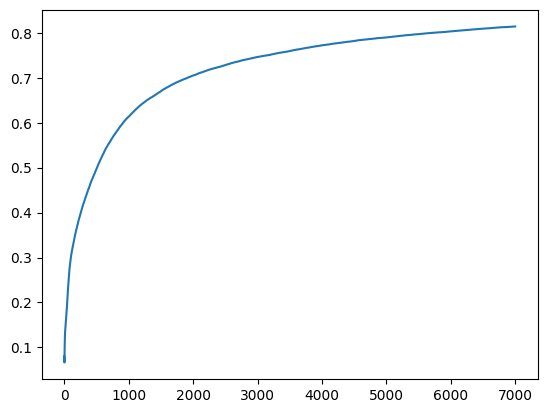

Epoch : 0 	 Loss : 66.28 	 Accuracy : 0.125400
Epoch : 100 	 Loss : 18.82 	 Accuracy : 0.218283
Epoch : 200 	 Loss : 15.41 	 Accuracy : 0.312800
Epoch : 300 	 Loss : 14.15 	 Accuracy : 0.374150
Epoch : 400 	 Loss : 13.53 	 Accuracy : 0.424083
Epoch : 500 	 Loss : 13.18 	 Accuracy : 0.464350
Epoch : 600 	 Loss : 12.96 	 Accuracy : 0.496183
Epoch : 700 	 Loss : 12.81 	 Accuracy : 0.523400
Epoch : 800 	 Loss : 12.70 	 Accuracy : 0.547533
Epoch : 900 	 Loss : 12.62 	 Accuracy : 0.566783
Epoch : 1000 	 Loss : 12.55 	 Accuracy : 0.583017
Epoch : 1100 	 Loss : 12.49 	 Accuracy : 0.598017
Epoch : 1200 	 Loss : 12.45 	 Accuracy : 0.611667
Epoch : 1300 	 Loss : 12.41 	 Accuracy : 0.624017
Epoch : 1400 	 Loss : 12.37 	 Accuracy : 0.634833
Epoch : 1500 	 Loss : 12.34 	 Accuracy : 0.644800
Epoch : 1600 	 Loss : 12.31 	 Accuracy : 0.653283
Epoch : 1700 	 Loss : 12.28 	 Accuracy : 0.661033
Epoch : 1800 	 Loss : 12.26 	 Accuracy : 0.668067
Epoch : 1900 	 Loss : 12.23 	 Accuracy : 0.675533
Epoch : 2000

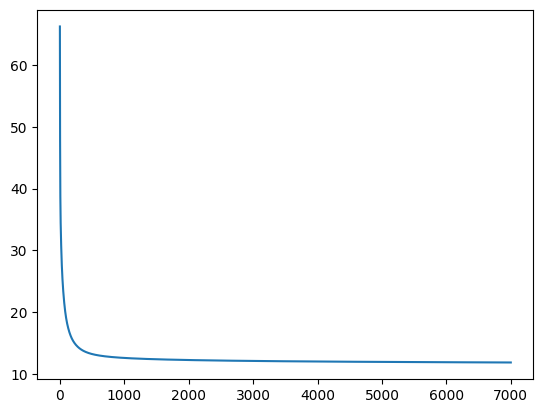

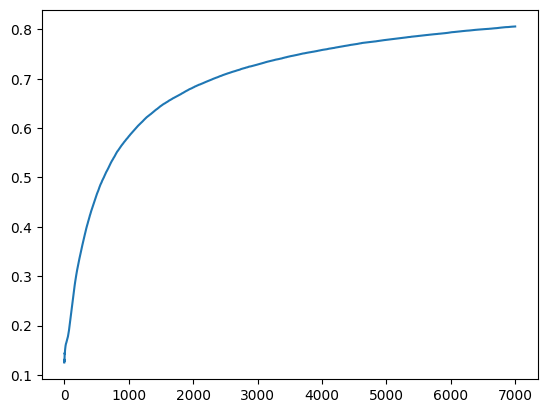

Epoch : 0 	 Loss : 59.73 	 Accuracy : 0.134617
Epoch : 100 	 Loss : 20.13 	 Accuracy : 0.297617
Epoch : 200 	 Loss : 16.25 	 Accuracy : 0.389267
Epoch : 300 	 Loss : 14.58 	 Accuracy : 0.446567
Epoch : 400 	 Loss : 13.71 	 Accuracy : 0.488433
Epoch : 500 	 Loss : 13.22 	 Accuracy : 0.525867
Epoch : 600 	 Loss : 12.92 	 Accuracy : 0.557917
Epoch : 700 	 Loss : 12.72 	 Accuracy : 0.585717
Epoch : 800 	 Loss : 12.58 	 Accuracy : 0.608883
Epoch : 900 	 Loss : 12.49 	 Accuracy : 0.628117
Epoch : 1000 	 Loss : 12.42 	 Accuracy : 0.644783
Epoch : 1100 	 Loss : 12.36 	 Accuracy : 0.657867
Epoch : 1200 	 Loss : 12.31 	 Accuracy : 0.669350
Epoch : 1300 	 Loss : 12.27 	 Accuracy : 0.679467
Epoch : 1400 	 Loss : 12.24 	 Accuracy : 0.689183
Epoch : 1500 	 Loss : 12.21 	 Accuracy : 0.696933
Epoch : 1600 	 Loss : 12.19 	 Accuracy : 0.704483
Epoch : 1700 	 Loss : 12.16 	 Accuracy : 0.711350
Epoch : 1800 	 Loss : 12.14 	 Accuracy : 0.717317
Epoch : 1900 	 Loss : 12.13 	 Accuracy : 0.722100
Epoch : 2000

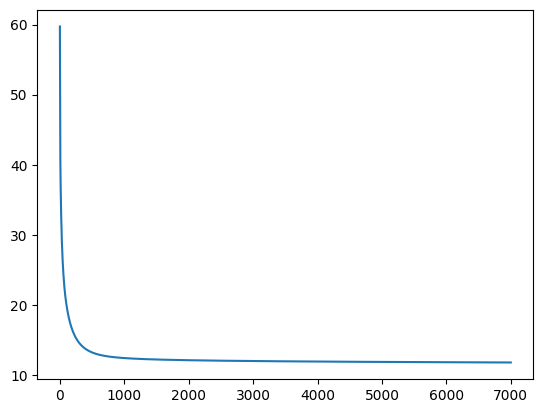

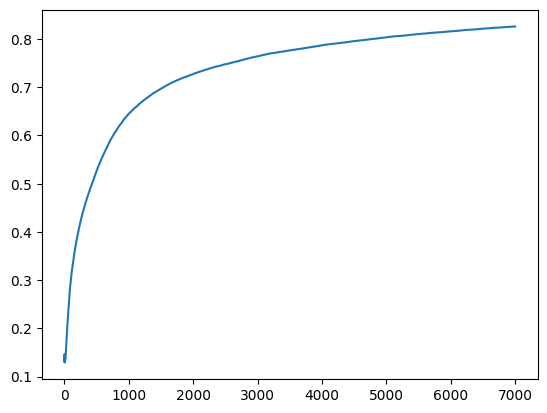

Epoch : 0 	 Loss : 55.87 	 Accuracy : 0.091367
Epoch : 100 	 Loss : 19.38 	 Accuracy : 0.249550
Epoch : 200 	 Loss : 15.60 	 Accuracy : 0.334283
Epoch : 300 	 Loss : 14.19 	 Accuracy : 0.390567
Epoch : 400 	 Loss : 13.52 	 Accuracy : 0.439233
Epoch : 500 	 Loss : 13.16 	 Accuracy : 0.478533
Epoch : 600 	 Loss : 12.93 	 Accuracy : 0.511083
Epoch : 700 	 Loss : 12.78 	 Accuracy : 0.537367
Epoch : 800 	 Loss : 12.67 	 Accuracy : 0.559717
Epoch : 900 	 Loss : 12.58 	 Accuracy : 0.579550
Epoch : 1000 	 Loss : 12.51 	 Accuracy : 0.596000
Epoch : 1100 	 Loss : 12.46 	 Accuracy : 0.611267
Epoch : 1200 	 Loss : 12.41 	 Accuracy : 0.623983
Epoch : 1300 	 Loss : 12.37 	 Accuracy : 0.636250
Epoch : 1400 	 Loss : 12.33 	 Accuracy : 0.646733
Epoch : 1500 	 Loss : 12.30 	 Accuracy : 0.656367
Epoch : 1600 	 Loss : 12.27 	 Accuracy : 0.666000
Epoch : 1700 	 Loss : 12.25 	 Accuracy : 0.673733
Epoch : 1800 	 Loss : 12.22 	 Accuracy : 0.681400
Epoch : 1900 	 Loss : 12.20 	 Accuracy : 0.688183
Epoch : 2000

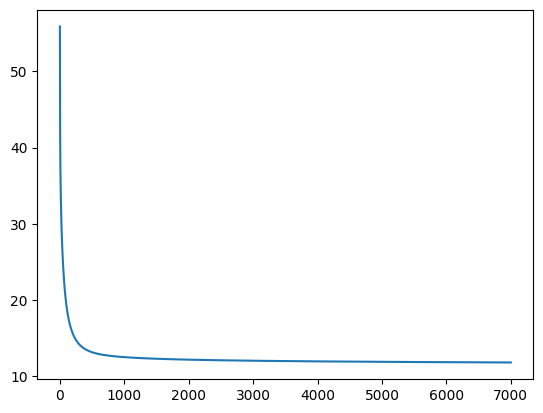

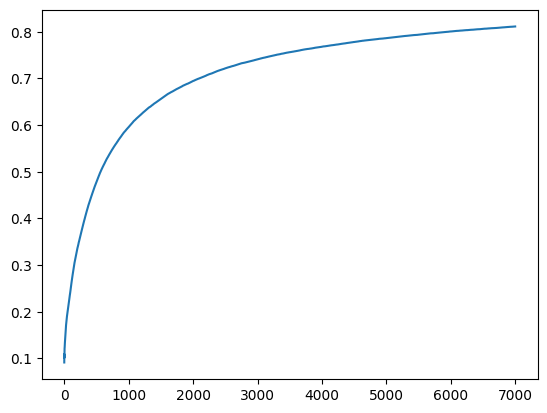

In [8]:
result = {}
i = 0
for s in range(10):
    seed = jax.random.PRNGKey(s)
    learning_rate = jnp.array(1e-2)
    epochs = 7000
    layer_sizes = [50, 10]

    initial_weights = InitializeWeights(layer_sizes, seed)
    weights = []
    for weight in initial_weights:
        weights.append([jnp.copy(weight[0]), jnp.copy(weight[1])])

    losses, accuracies, saved_weights = TrainModel(weights, x_train, y_train, learning_rate, epochs, mask = None, verbose_epoches = 100)
    result[i] = saved_weights

    plt.plot(losses)
    plt.show()

    plt.plot(accuracies)
    plt.show()
    i+=1
    

In [9]:
def weights_vector(weights):
    w0_shape = weights[0][0].shape
    b0_shape = weights[0][1].shape
    w1_shape = weights[1][0].shape
    b1_shape = weights[1][1].shape 

    all_weights = []
    for weight in weights: 
        w = weight[0]
        b = weight[1]
        for row in w:
            for elem in row:
                all_weights.append(elem)
        for elem in b:
            all_weights.append(elem)
    return all_weights

def random_prune(weights, prune_part = 0.1):
    w0_shape = weights[0][0].shape
    b0_shape = weights[0][1].shape
    w1_shape = weights[1][0].shape
    b1_shape = weights[1][1].shape 
    all_weights = np.array(weights_vector(weights))

    prune_indeces = list(np.random.choice(len(all_weights), size = int(prune_part * len(all_weights)), replace = False))
    all_weights[prune_indeces] = 0 

    new_weights = []

    w0 = np.zeros(w0_shape)
    for i in range(w0_shape[0]):
      row = np.zeros(w0_shape[1])
      for j in range(w0_shape[1]):
        row[j] = all_weights[i*w0_shape[1]+j]
      w0[i] = row
    b0 = np.zeros(b0_shape)
    for i in range(b0_shape[0]):
      b0[i] = all_weights[w0_shape[1] * w0_shape[0] + i]

    w1 = np.zeros(w1_shape)
    for i in range(w1_shape[0]):
      row = np.zeros(w1_shape[1])
      for j in range(w1_shape[1]):
        row[j] = all_weights[w0_shape[1] * w0_shape[0] + b0_shape[0] + i*w1_shape[1]+j]
      w1[i] = row
    b1 = np.zeros(b1_shape)
    for i in range(b1_shape[0]):
      b1[i] = all_weights[w0_shape[1] * w0_shape[0] + b0_shape[0] + w1_shape[1] * w1_shape[0] + i]

    new_weights = [[jnp.array(w0), jnp.array(b0)],
                   [jnp.array(w1), jnp.array(b1)]]

    return new_weights, all_weights
    
    


In [28]:
accuracies = []
weights_vectors = []
for i in range(10):
  weights = result[i][6900]["weights"]
  for prune_part in [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
     for j in range(10):
        new_weights, all_weights = random_prune(weights, prune_part)
        weights_vectors.append(all_weights)
        accuracies.append(Accuracy(new_weights, x_train, y_train,None))
        print(i, prune_part,j, accuracies[-1])


0 0 0 0.80586666
0 0 1 0.80586666
0 0 2 0.80586666
0 0 3 0.80586666
0 0 4 0.80586666
0 0 5 0.80586666
0 0 6 0.80586666
0 0 7 0.80586666
0 0 8 0.80586666
0 0 9 0.80586666
0 0.05 0 0.7701333
0 0.05 1 0.7726167
0 0.05 2 0.70133334
0 0.05 3 0.7367667
0 0.05 4 0.7691333
0 0.05 5 0.75248337
0 0.05 6 0.75235003
0 0.05 7 0.7392167
0 0.05 8 0.7733667
0 0.05 9 0.74113333
0 0.1 0 0.7048333
0 0.1 1 0.7029
0 0.1 2 0.7377
0 0.1 3 0.69805
0 0.1 4 0.71333337
0 0.1 5 0.68688333
0 0.1 6 0.6556
0 0.1 7 0.72693336
0 0.1 8 0.6907167
0 0.1 9 0.6698167
0 0.2 0 0.47585002
0 0.2 1 0.5478
0 0.2 2 0.66471666
0 0.2 3 0.53245
0 0.2 4 0.60895
0 0.2 5 0.5883
0 0.2 6 0.6153167
0 0.2 7 0.55698335
0 0.2 8 0.53403336
0 0.2 9 0.59145004
0 0.3 0 0.33201668
0 0.3 1 0.48581666
0 0.3 2 0.45871666
0 0.3 3 0.43676668
0 0.3 4 0.41783333
0 0.3 5 0.44976667
0 0.3 6 0.47985
0 0.3 7 0.5521667
0 0.3 8 0.46605
0 0.3 9 0.5448167
0 0.4 0 0.44543335
0 0.4 1 0.32353333
0 0.4 2 0.29348335
0 0.4 3 0.31445
0 0.4 4 0.31683335
0 0.4 5 0.28388

In [29]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

pca = PCA(2)
small_weights_vectors_pca = pca.fit_transform(np.array(weights_vectors))

[]

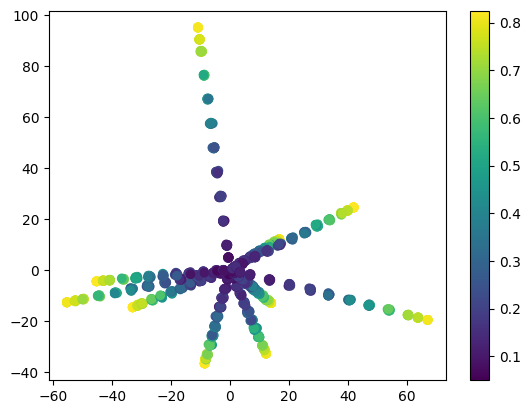

In [30]:
plt.scatter(small_weights_vectors_pca[:,0], 
            small_weights_vectors_pca[:, 1], 
            c = accuracies)
plt.colorbar()
plt.plot()

In [31]:
tsne = TSNE()
pca = PCA(100)
weights_vectors_pca = pca.fit_transform(np.array(weights_vectors))
small_weights_vectors_tsne = tsne.fit_transform(weights_vectors_pca)

[]

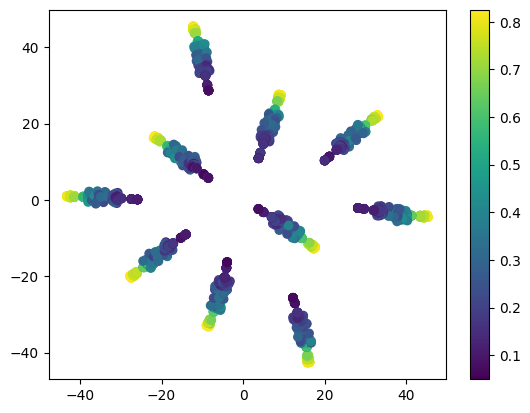

In [32]:
plt.scatter(small_weights_vectors_tsne[:,0], 
            small_weights_vectors_tsne[:, 1], 
            c = accuracies)
plt.colorbar()
plt.plot()

[]

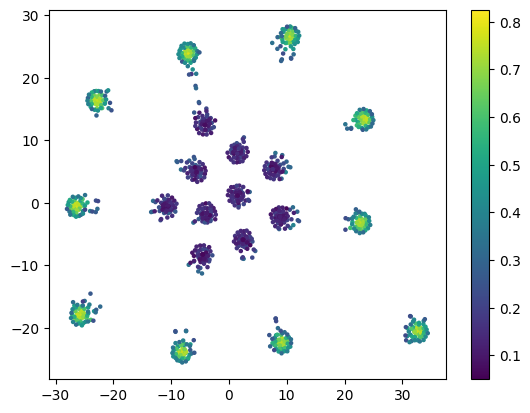

In [34]:
tsne = TSNE()
small_weights_vectors_tsne = tsne.fit_transform(np.array(weights_vectors))
plt.scatter(small_weights_vectors_tsne[:,0], 
            small_weights_vectors_tsne[:, 1], 
            c = accuracies, s = 5)
plt.colorbar()
plt.plot()

## Conclusion

On the picture we can distinguish original models from which were pruned the other ones. Also models with a lot of pruned parameters are close to each other (and close to zero).